In [657]:
import torch
from torch import nn
from torch import optim

from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import numpy as np
from PIL import Image

from tqdm import tqdm

import matplotlib.pyplot as plt

import glob, json
import os

In [658]:
with open('dataset_image_names.json', 'w') as f:
  f.write(json.dumps(glob.glob('images/*')))

In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Device: {device}")

Device: cpu


In [126]:
class AnimeDataset(Dataset):
  def __init__(self, path, transform):
    super(AnimeDataset, self).__init__()
    self.path = path
    self.transform = transform
    self.images = glob.glob(os.path.join(self.path, '*'))

  def __len__(self):
    return len(self.images)

  def __getitem__(self, index):
    X = self.transform(Image.open(self.images[index]))
    return X

  def __repr__(self):
    return f"<AnimeDataset len:{len(self.images)}>"

transform = transforms.Compose([
  transforms.Resize((64, 64)),
  transforms.RandomHorizontalFlip(),
  transforms.ToTensor(),
  transforms.Normalize(0.0, 1.0)
])

dataset = AnimeDataset('./images', transform)

In [212]:
train_dl = DataLoader(dataset, 32, shuffle=True)

X_batch = next(iter(train_dl))

In [153]:
class ConvBlock(nn.Module):
  def __init__(self, ch_in, ch_out):
    super(ConvBlock, self).__init__()
    self.block = nn.Sequential(
      nn.Conv2d(ch_in, ch_out, 3, 2, 1, bias=False),
      nn.BatchNorm2d(ch_out),
      nn.LeakyReLU(0.02)
    )
  def forward(self, X):
    return self.block(X)

In [209]:
class ConvTBlock(nn.Module):
  def __init__(self, ch_in, ch_out, dropout = True, sigmoid=False):
    super(ConvTBlock, self).__init__()
    self.block = nn.Sequential(
      nn.ConvTranspose2d(ch_in, ch_out, 3, 2, 1, output_padding=1),
      nn.Dropout2d(0.25) if dropout else nn.Identity(),
      nn.Sigmoid() if sigmoid else nn.ReLU()
    )
  def forward(self, X):
    return self.block(X)

In [715]:
class OwoEncoder(nn.Module):
  def __init__(self):
    super(OwoEncoder, self).__init__()
    self.encoder = nn.Sequential(
      ConvBlock(3, 32),
      ConvBlock(32, 64),
      ConvBlock(64, 128),
      ConvBlock(128, 256),
      ConvBlock(256, 512),
      nn.Conv2d(512, 1028, 2),
      nn.LeakyReLU(0.02)
    )
    self.linear_std = nn.Linear(1028, 32)
    self.linear_mean = nn.Linear(1028, 32)
    self.decoder = nn.Sequential(
      nn.ConvTranspose2d(32, 512, 2),
      nn.ReLU(),
      ConvTBlock(512, 256),
      ConvTBlock(256, 128),
      ConvTBlock(128, 64),
      ConvTBlock(64, 32),
      ConvTBlock(32, 3, False, True),
    )
    
  def forward(self, X):
    features = torch.flatten(self.encoder(X), start_dim=1, end_dim=-1)
    mean = self.linear_mean(features)
    std = self.linear_std(features)
    norm = torch.randn_like(std)*std + mean
    z = norm.unsqueeze(-1).unsqueeze(-1)
    fake = self.decoder(z)
    return fake, mean, std

model = OwoEncoder()
fake, mean, std = model(X_batch)
fake.shape, mean.shape, std.shape

optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-8)
bce_loss_fn = nn.BCELoss()
kl_loss_fn = lambda mean, std: (-0.5*(1 + torch.log(std**2) - mean**2 - std**2).sum(1)).mean()

In [749]:
for i in range(10):
  train_loss = .0
  for X_batch in tqdm(train_dl):
    
    model.train()
    fake, mean, std = model(X_batch)

    bce_loss = bce_loss_fn(fake, X_batch)
    kl_loss = kl_loss_fn(mean, std)

    loss = bce_loss + kl_loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    train_loss += loss.item() * X_batch.shape[0]
  
  train_loss /= len(train_dl.dataset)

  print(train_loss)

100%|██████████| 98/98 [00:35<00:00,  2.74it/s]


0.6670786405709721


100%|██████████| 98/98 [00:34<00:00,  2.82it/s]


0.6646400245096927


100%|██████████| 98/98 [00:34<00:00,  2.80it/s]


0.6619373525575505


100%|██████████| 98/98 [00:35<00:00,  2.78it/s]


0.6595527492093566


100%|██████████| 98/98 [00:35<00:00,  2.80it/s]


0.6582643207125617


100%|██████████| 98/98 [00:36<00:00,  2.68it/s]


0.65617111177255


 10%|█         | 10/98 [00:04<00:40,  2.15it/s]


KeyboardInterrupt: 

In [719]:
train_loss

1126.0916748046875

In [735]:
X_batch.shape

torch.Size([32, 3, 64, 64])

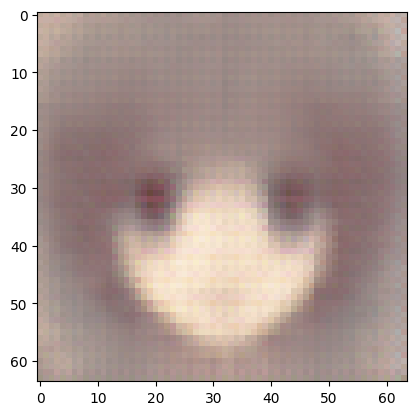

In [750]:
z = model.decoder(torch.randn(1, 32, 1, 1))
z = z.detach().moveaxis(1, -1)[0].numpy()
plt.imshow(z)

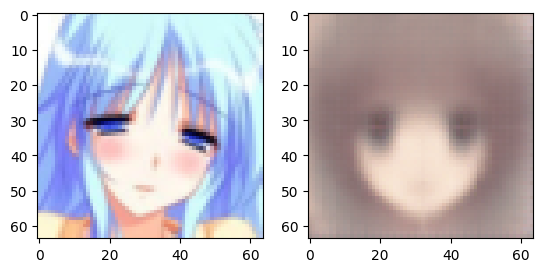

In [751]:
X_batch = next(iter(train_dl))

model.eval()
fake, _, _ = model(X_batch[:1,:,:,:])

plt.subplot(1, 2, 1)
plt.imshow(X_batch[0].moveaxis(0, 2).numpy())
plt.subplot(1, 2, 2)
plt.imshow(fake.detach()[0].moveaxis(0, 2).numpy())